#### Laurent Jutras-Dubé

## The gene-free models: stochastic simulations

####   

**1. Stochastic pattern formation with the gene-free models**

In this notebook, we perform stochastic simulations on the gene-free models, and compare the results for the model with a Hopf biurcation to the results for the model with a SNIC bifurcation. To perform stochastic simulations, we add gaussian noise with a fixed variance. We do not apply the Langevin method, since the ODEs of the gene-free models do not explicitly represent reactions between molecular species. In the last section of this notebook, we quantify the robustness of the patterns obtained in each model via the mutual information metric. See the Methods and the Supplement for more details.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

####    

**1.1 The ODEs**

We define functions for the static, dynamic and intermediate terms, and a global derivative function that includes the 3 terms and parameter $g$. We specify the values of all parameters later in this notebook.

In [2]:
def dynamic(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    r = np.sqrt(y*y+z*z)
    
    dy = y*(1.-r) -z
    dz = z*(1.-r) +y
    
    return np.array([dy, dz]).transpose()



def static(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = y*(1.-y*y)
    dz = -z
    
    return np.array([dy, dz]).transpose()



def intermediate(vec):
    
    y = vec[:,0]
    z = vec[:,1]
    
    dy = -y
    dz = -z
    
    return np.array([dy, dz]).transpose()



def dvec(vec, g, param):
    
    g = np.array([g, g]).transpose()
    ng = param["ng"]
    if_interm = param["if_interm"]
    
    return g**ng*dynamic(vec) +(1.-g)**ng*static(vec) +if_interm*g*(1.-g)*intermediate(vec)

####    

**1.2 The spatio-temporal profile of parameter _g_**

In a given cell, the value of $g$ stays equal to 1 for some time (via the `x_osc` parameter) before decreasing exponentially (via the `s` parameter). To generate a spatial pattern, we make the time at which the value of $g$ starts decreasing, $t^*$, dependent on the position of the cell in the tissue: $t^*(x)$. To model a tissue growing with a constant speed, we make $t^*(x)$ a linear function of $x$, via the `positions` vector and the `v` parameter. In other words, we model a gradient of $g$ with a fixed steepness that moves in the posterior direction at a constant rate. We generate a kymograph showing the spatio-temporal profile of $g$ later in this notebook.

In [3]:
def compute_g(t, param):
    
    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    positions = np.linspace(0.0, 1.0, param["n_cells"])
    
    g = np.exp(s*(positions +x_osc -v*t))
    g[g > 1.] = 1.
    
    return g

####  

**1.3 The integration scheme**

The `integrate` function requires two inputs:  the initial vector of $y$ and $z$ components at all spatial positions, and the dictionary of parameters. Parameter `n_steps_keep_results` specifies the number of integration steps between which the simulation results are kept. Increasing this parameter can help reduce the size of the 3 output matrices, `results`, `g_gradient` and `times_plot`. These matrices contain respectively the values of $y$ and $z$ at all positions for every time point, the spatio-temporal distribution of parameter $g$ and the array of times. Note that the only difference with the `integrate` function used for deterministic simulations is the inclusion of a stochastic term proportional to $\frac{dt}{\sqrt{\Omega}}$.

We model a gradient of $g$ with a fixed steepness that moves posteriorly at a rate given by the parameter `v`. This is similar to the somite formation process, during which the tissue grows via the gradual addition of new cells at its posterior end. From this point of view, parameter `v` corresponds to the velocity of elongation of the embryo. To stay coherent with the somitogenesis picture, we start decoupling the noise in a cell from the noise inside the cells posterior to it at that same rate. Therefore, we model the oscillations at the most posterior part of the tissue as being generated by a (noisy) pacemaker cell that "divides" at a fixed rate. In other words, a cell effectively enters the tissue when the noise in its genetic oscillations is not the same as the noise in the genetic oscillations of the (posterior) pacemaker cell.

In [4]:
def integrate(init_conc, param):

    # Set the integration parameters
    total_t = param["total_t"]
    dt = param["dt"]
    times = np.arange(0., total_t, dt)
    times_plot = [0.]

    vec = init_vec
    results = [vec]
    g = compute_g(0., param)
    g_gradient = [g]
    omega = param["omega"]
    
    counter = 0
    n_steps_keep_results = param["n_steps_keep_results"]

    
    # Perform the integration
    for t in times[1:]:
        
        # Compute noise
        noise = np.random.normal(loc=0., scale=1., size=vec.shape)
        
        # Introduce noise in the cells at a fixed rate
        x_posterior_psm = int(t*param["v"]*param["n_cells"])
        if (x_posterior_psm < param["n_cells"]):    
            noise[x_posterior_psm:] = noise[x_posterior_psm]
            
        # Update the state vector
        vec = vec +dvec(vec, g, param)*dt +noise*np.sqrt(dt/omega)
        g = compute_g(t, param)
           
        counter += 1
        if (counter %n_steps_keep_results == 0):
            results.append(vec)
            g_gradient.append(g)
            times_plot.append(t)
        

    # Output the results
    results = np.array(results)
    g_gradient = np.array(g_gradient)
    times_plot = np.array(times_plot)
    
    return results, g_gradient, times_plot

####  

**1.4 The kymograph plots**

We visualize the results of the integration with a kymograph where the horizontal axis is time and the vertical axis is the position of the cell along the tissue. On this kymograph, we represent the value of the $y$ component with a color gradient. We do not represent the $z$ component since it is always equal to 0 in the spatial pattern, and therefore does not provide any positional information.

We plot lines representing the moment at which $g$ starts decreasing for the different positions along the tissue. We also plot lines for the moments at which $g$ reaches specific values, namely 0.5 and 0.2. To achieve this, we need to define a function `compute_x` that outputs the position of the cell that has a given value of $g$ at a given time, and a function `compute_t` that outputs the time at which $g$ has a given value at a given position along the tissue.

In [5]:
def compute_x(g, t, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return np.log(g)/s -x_osc +v*t



def compute_t(g, x, param):

    x_osc = param["x_osc"]
    s = param["s"]
    v = param["v"]
    
    return (x_osc +x -np.log(g)/s)/v
    

    
def plot_kymograph(results, g_gradient, times_plot, param):
    
    plt.rcParams["figure.figsize"] = 6.4, 4.8
    fig, ax = plt.subplots()
    
    # Kymograph
    norm = colors.Normalize(vmin=-1., vmax=1.)
    kymo = ax.imshow(results[:,:,0].transpose(), norm=norm, cmap='Blues', aspect='auto')
    
    # Colorbar
    cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[-1., 0., 1.])
    cb.ax.tick_params(labelsize=24)
    
    # Lines of constant g
    ax.plot(param["n_cells"]*compute_x(1., times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.5, times_plot, param), color='k', linewidth=4)
    ax.plot(param["n_cells"]*compute_x(0.2, times_plot, param), color='k', linewidth=4)
    
    ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='k', rotation=-76, fontsize=24)
    ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-76, fontsize=24)
    ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-76, fontsize=24)
    
    # Other plot options
    ax.set_title('$y(x,t)$    $\Omega=$'+str(int(param["omega"])), fontsize=32)
    ax.set_xlabel('$t$', fontsize=32)
    ax.set_ylabel('$x$', fontsize=32)
    ax.set_ylim([param["n_cells"], 0])
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.show()

####  

**1.5 The stochastic dynamics of pattern formation in the gene-free models**

We define all the parameters required for the ODEs, the morphogen gradient and the integration. We then use the `integrate` function to perform the integration and the `plot_kymograph` function to visualise the results. In Model 1, we set `ng` to 3 and `if_interm` to 1, while in Model 2 we set `ng` to 1 and `if_interm` to 0.

<IPython.core.display.Javascript object>


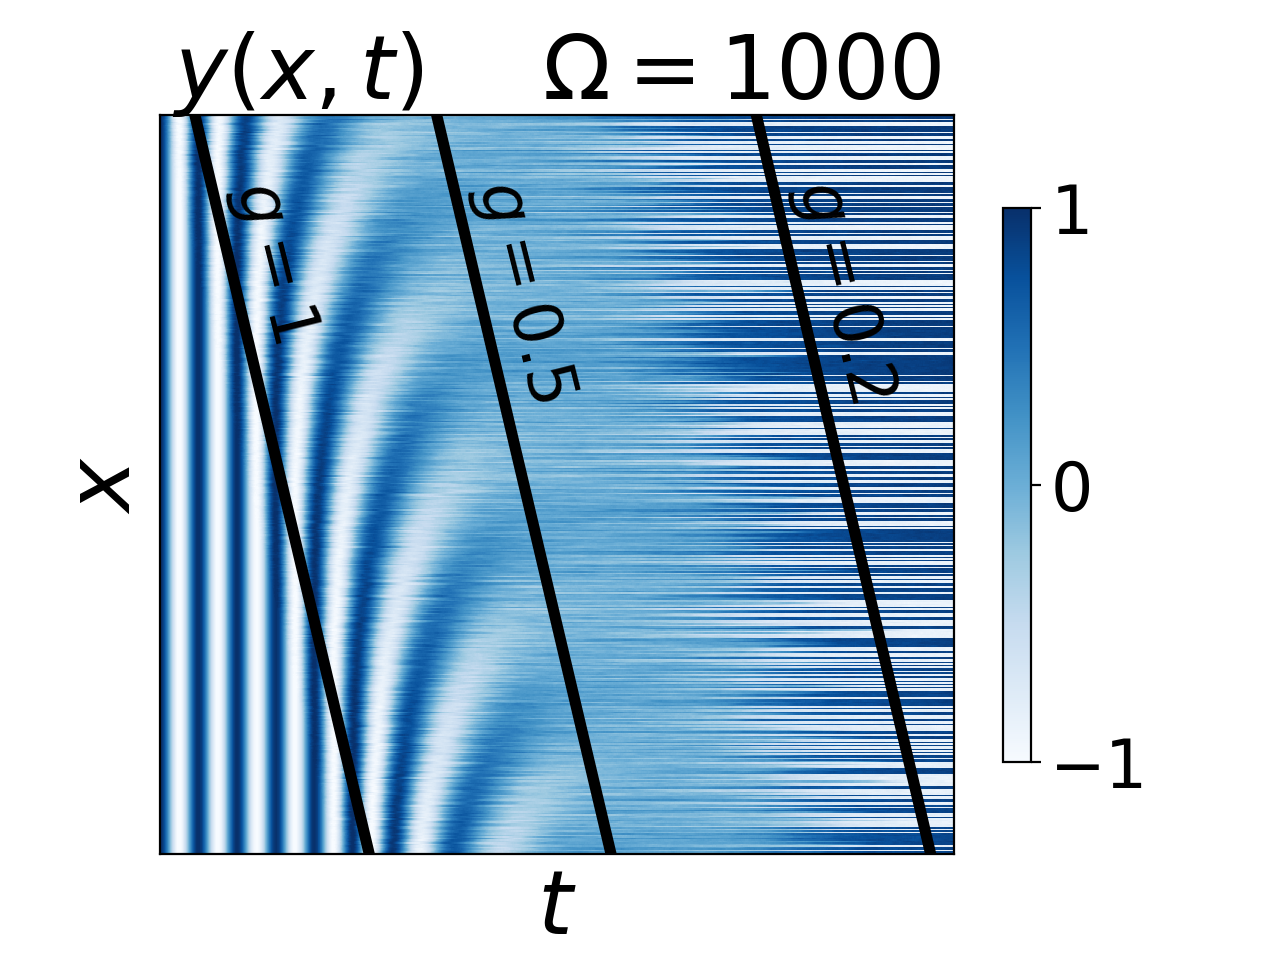

<IPython.core.display.Javascript object>


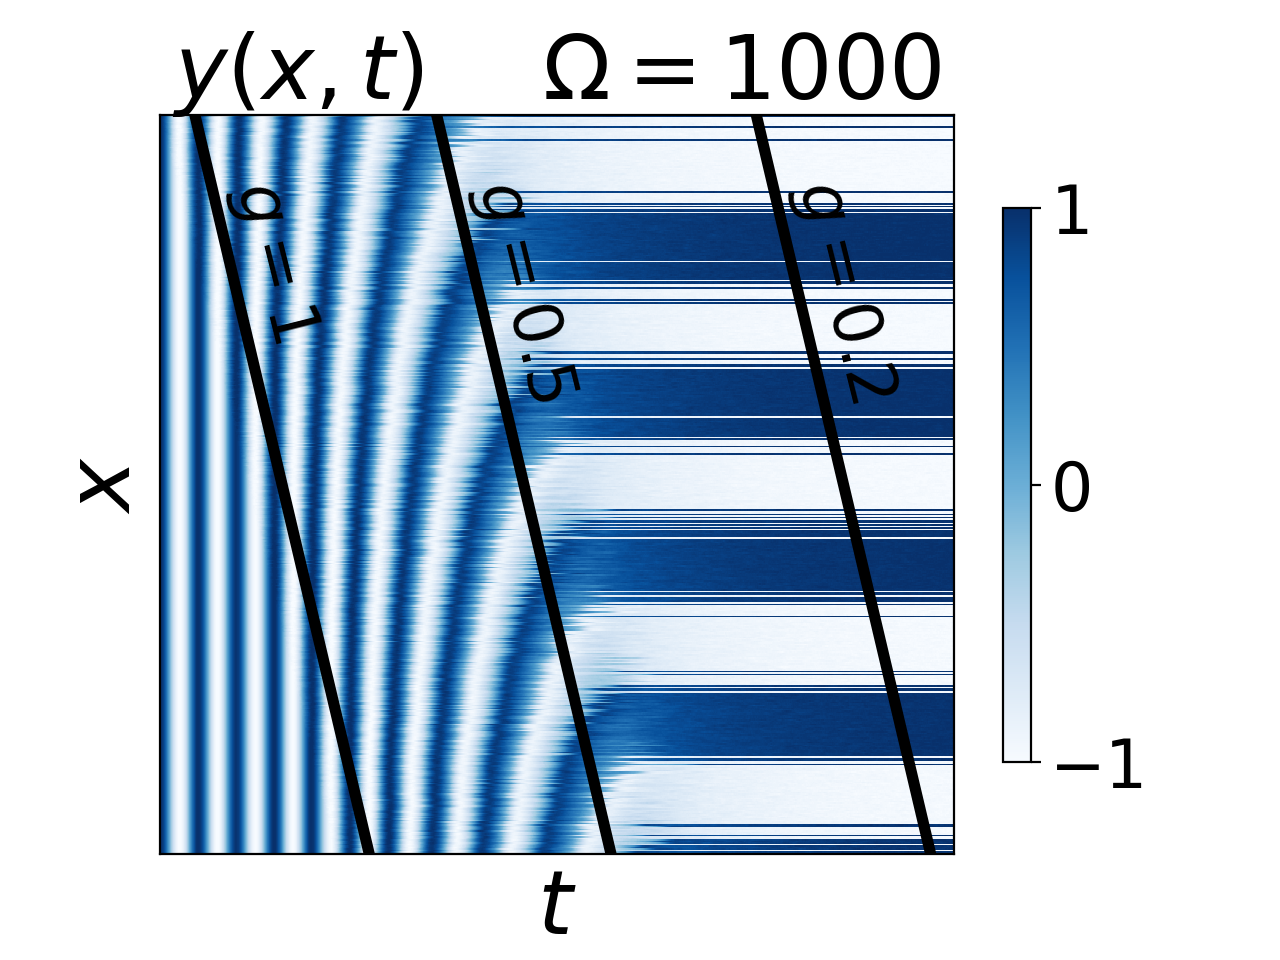

In [6]:
param ={
    
    # ODE parameters
    "ng"        : 3,
    "if_interm" : 1.,
    
    # Morphogen gradient parameters
    "x_osc"   : 0.2,
    "s"       : 0.5,
    "v"       : 0.035,
    "n_cells" : 500,
    
    # Integration parameters
    "total_t"              : 130.,
    "dt"                   : 0.01,
    "n_steps_keep_results" : 1,
    "omega"                : 1000.
}


init_vec = np.zeros((param["n_cells"], 2))
init_vec[:,0] = 1.


# Gene-free model with a Hopf bifurcation (Model 1)
param["ng"] = 3
param["if_interm"] = 1.
results_noise_Hopf, g_gradient_noise_Hopf, times_plot_noise_Hopf = integrate(init_vec, param)
plot_kymograph(results_noise_Hopf, g_gradient_noise_Hopf, times_plot_noise_Hopf, param)


# Gene-free model with a SNIC bifurcation (Model 2)
param["ng"] = 1
param["if_interm"] = 0.
results_noise_SNIC, g_gradient_noise_SNIC, times_plot_noise_SNIC = integrate(init_vec, param)
plot_kymograph(results_noise_SNIC, g_gradient_noise_SNIC, times_plot_noise_SNIC, param)

As expected, the patterns obtained with both models are quite noisy. However, in the stochastic pattern of Model 2 any given region of the simulated tissue is clearly dominated by the fixed point of the same region in the deterministic pattern. This is not the case for Model 1.

In the next code cell, we plot the $y$ and $z$ components in a single cell as a function of time for both versions of the model. We choose arbitrarily the most anterior cell.

<IPython.core.display.Javascript object>


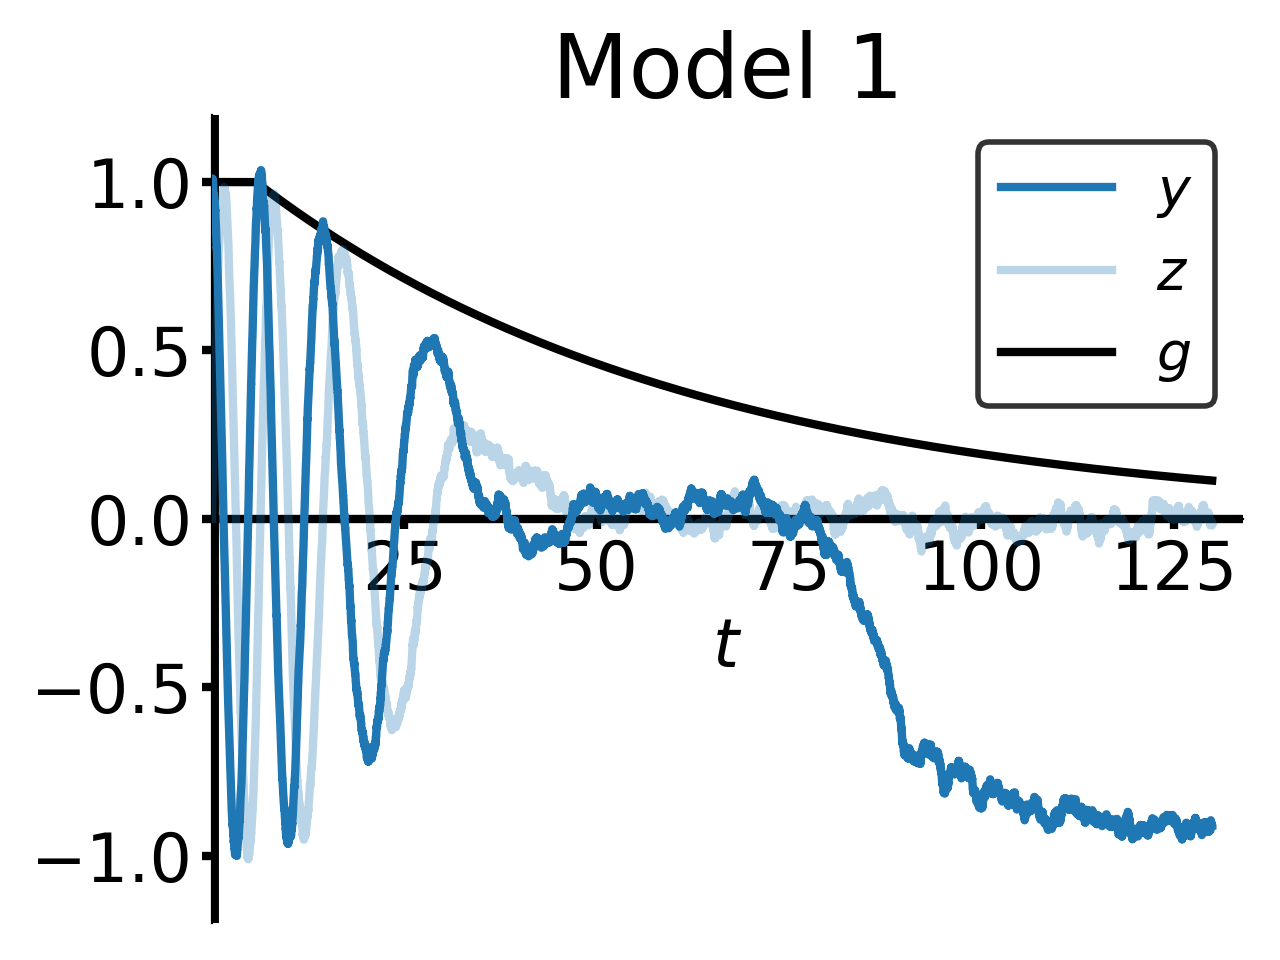

<IPython.core.display.Javascript object>


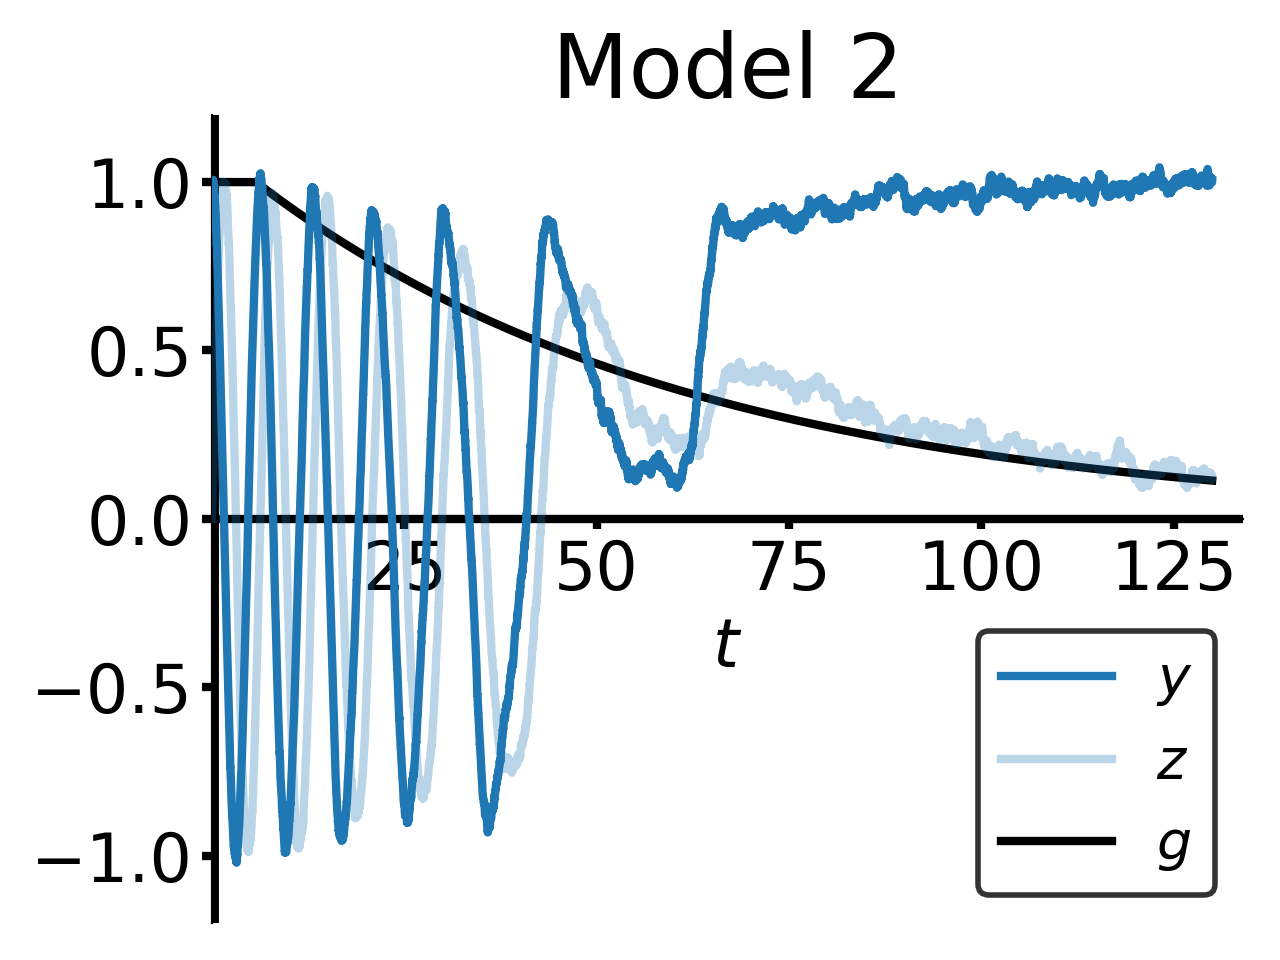

In [7]:
# Gene-free model with a Hopf bifurcation (Model 1)
plt.rcParams["figure.figsize"] = 6.4,4.8
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_Hopf, results_noise_Hopf[:,0,0], c='tab:blue', lw=3, label='$y$', zorder=10)
ax.plot(times_plot_noise_Hopf, results_noise_Hopf[:,0,1], c='tab:blue', lw=3, alpha=0.3, label='$z$', zorder=9)
ax.plot(times_plot_noise_Hopf, g_gradient_noise_Hopf[:,0], c='k', lw=3, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Legend
legend = ax.legend(fontsize=20, edgecolor='k')
legend.get_frame().set_linewidth(2)

# Other plot options
ax.set_title('Model 1', fontsize=32)
ax.set_xlabel('$t$', fontsize=24)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=3, color='k')
ax.axvline(linewidth=5, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([25., 50., 75., 100., 125.])
ax.tick_params(labelsize=24, width=3)

fig.tight_layout()
fig.show()



# Gene-free model with a SNIC bifurcation (Model 2)
plt.rcParams["figure.figsize"] = 6.4,4.8
fig, ax = plt.subplots()

# Trajectory
ax.plot(times_plot_noise_SNIC, results_noise_SNIC[:,0,0], c='tab:blue', lw=3, label='$y$', zorder=10)
ax.plot(times_plot_noise_SNIC, results_noise_SNIC[:,0,1], c='tab:blue', lw=3, alpha=0.3, label='$z$', zorder=9)
ax.plot(times_plot_noise_SNIC, g_gradient_noise_SNIC[:,0], c='k', lw=3, label='$g$', zorder=8)

# Move bottom x-axis to center, and eliminate upper and right axes
ax.spines['bottom'].set_position('center')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Legend
legend = ax.legend(fontsize=20, edgecolor='k')
legend.get_frame().set_linewidth(2)

# Other plot options
ax.set_title('Model 2', fontsize=32)
ax.set_xlabel('$t$', fontsize=24)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([0.,param["total_t"]+4.])
ax.axhline(linewidth=3, color='k')
ax.axvline(linewidth=5, color='k')
ax.set_yticks([-1., -0.5, 0., 0.5, 1.])
ax.set_xticks([25., 50., 75., 100., 125.])
ax.tick_params(labelsize=24, width=3)

fig.tight_layout()
fig.show()

####   

In the next code cell, we generate a kymograph showing the spatio-temporal profile of $g$.

<IPython.core.display.Javascript object>


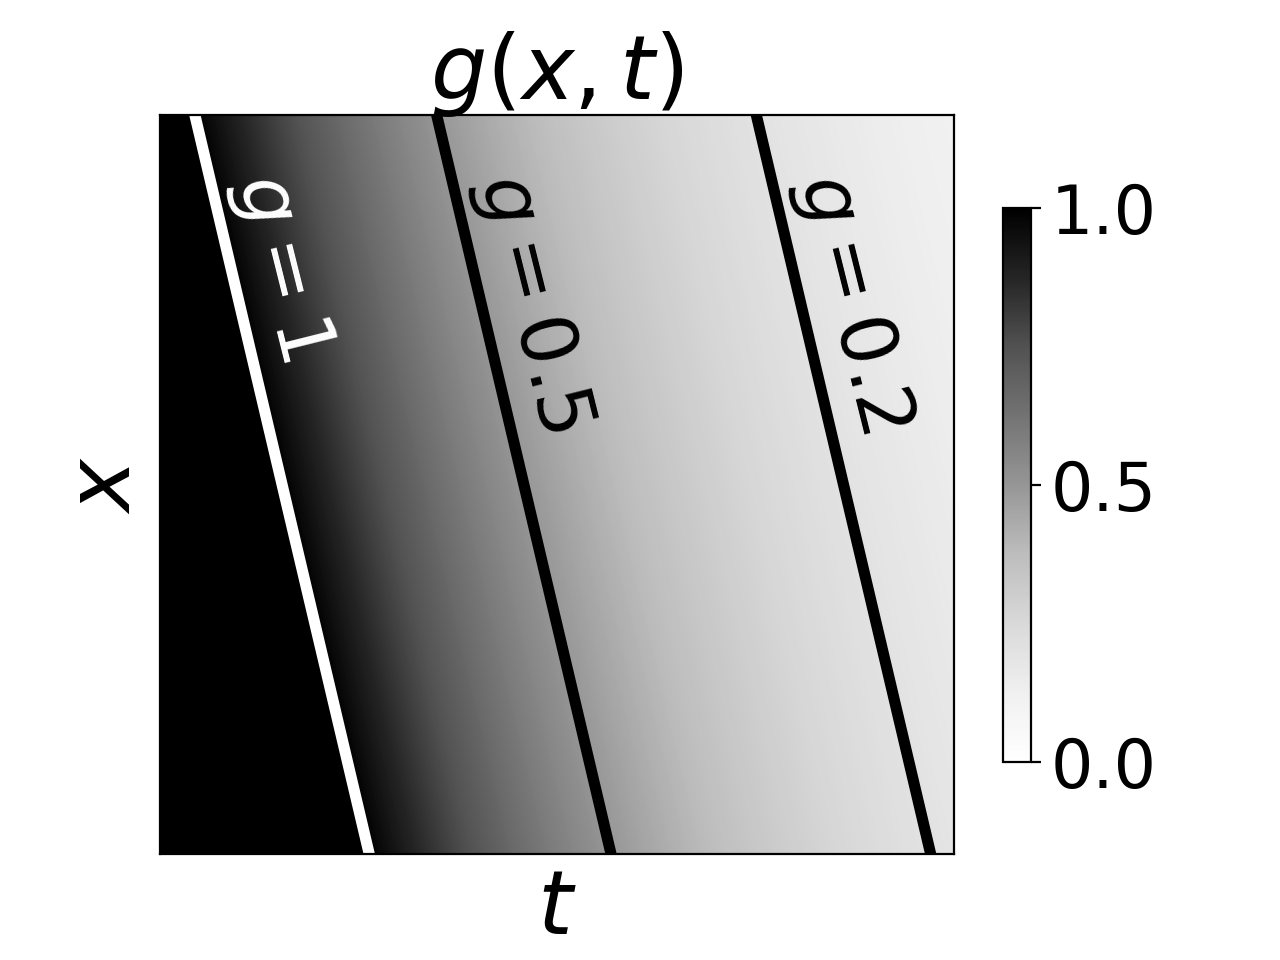

In [8]:
# Generate the kymograph of g
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Kymograph
norm = colors.Normalize(vmin=0., vmax=1.)
kymo = ax.imshow(g_gradient_noise_Hopf.transpose(), norm=norm, cmap='Greys', aspect='auto')
    
# Colorbar
cb = fig.colorbar(kymo, ax=ax, shrink=0.75, ticks=[0., 0.5, 1.])
cb.ax.tick_params(labelsize=24)
  
# Lines of constant g
ax.plot(param["n_cells"]*compute_x(1., times_plot_noise_Hopf, param), color='w', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.5, times_plot_noise_Hopf, param), color='k', linewidth=4)
ax.plot(param["n_cells"]*compute_x(0.2, times_plot_noise_Hopf, param), color='k', linewidth=4)
    
ax.text(compute_t(1., 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=1$', color='w', rotation=-76, fontsize=28)
ax.text(compute_t(0.5, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.5$', color='k', rotation=-76, fontsize=28)
ax.text(compute_t(0.2, 0.15, param)/param["dt"], param["n_cells"]*0.15, '$g=0.2$', color='k', rotation=-76, fontsize=28)
    
# Other plot options   
ax.set_title('$g(x,t)$', fontsize=32)
ax.set_xlabel('$t$', fontsize=32)
ax.set_ylabel('$x$', fontsize=32)
ax.set_ylim([param["n_cells"], 0])
ax.set_xticks([])
ax.set_yticks([])
    
fig.show()

####    

**2. Mutual information**

We now plot the mutual information between the phase along the cycle of oscillations at the beginning of the simulation and the region of the pattern at the end of the simulation. See the Methods and the Supplement for more details.

We first define a function that extracts the data before making the graph. The data is obtained with other python codes that are included in the `Mutual_info_data` folder. We do not include the codes directly in this notebook, since running them can take several hours. In short, we set all cells in the same initial state at the begining of the simulation, i.e. at the same phase of the oscillations. The probability of being in a given region of the pattern is calculated by computing the fixed point in which a given cell ends up at the end of the simulation. We repeat this procedure for different initial phases along the cycle. Since the elongation speed is constant, we sample the initial phases uniformly on the cycle.Because the simulations are stochastic, we repeat the whole procedure mutliple times to get reliable results.

We compute and plot the mutual information for different levels of noise. The ideal mutual information is obtained by setting the noise level to 0. Since the deterministic pattern is made of two symmetric regions, its information content is $\log(2)$ ~ $1$ bit.


####   

**2.1 Extracting the mutual information data**

In the next code cell, we define a function that extracts the data of the mutual information from the `.txt` files found in the `Mutual_info_data` folder. Each file has the mutual information for a given version of the model (Model 1, or 2). Therefore, we need to specify the model used to generate the data, via parameter `m_index`.

In [9]:
def extract_mutual_info(m_index):
    
    mutual_info = np.genfromtxt("Mutual_info_data/Gene-free_models/Gene-free_m"
                                +str(m_index)+"_MI.txt", delimiter=",")
    
    return mutual_info.transpose()

####   

**2.2 Generating the mutual information plot**

We first extract the mutual information data. Then, we plot the mutual information as a function of parameter $\Omega$. We plot a different line for each version of the model.

<IPython.core.display.Javascript object>


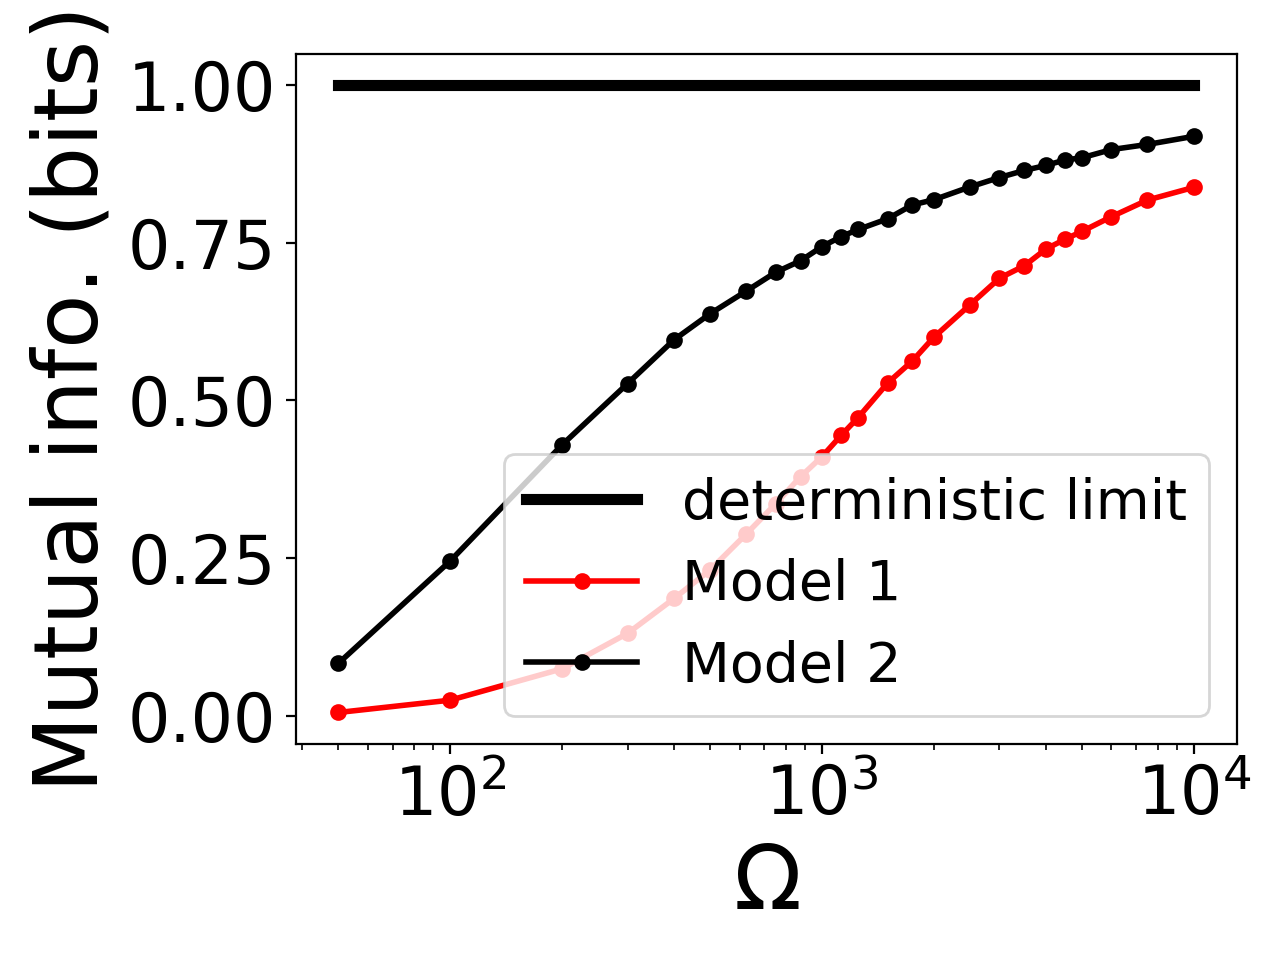

In [10]:
# Extract the data for both versions of the model
MI_m1 = extract_mutual_info(1)
MI_m2 = extract_mutual_info(2)


# Plot the mutual information
plt.rcParams["figure.figsize"] = 6.4, 4.8
fig, ax = plt.subplots()

# Deterministic limit
ax.semilogx([min(MI_m1[0,1:]), max(MI_m1[0,1:])], [MI_m1[1,0], MI_m1[1,0]], c='k', ls='-', lw=4, label='deterministic limit')

# Gene-free model with a Hopf bifurcation (Model 1)
ax.semilogx(MI_m1[0,1:], MI_m1[1,1:], color='r', marker='o', markersize=5, lw=2, label='Model 1')

# Gene-free model with a SNIC bifurcation (Model 2)
ax.semilogx(MI_m2[0,1:], MI_m2[1,1:], color='k', marker='o', markersize=5, lw=2, label='Model 2')

# Plot options
ax.set_xlabel('$\Omega$', fontsize=32)
ax.set_ylabel('Mutual info. (bits)', fontsize=32)
ax.tick_params(labelsize=24)
ax.legend(fontsize=20)

fig.tight_layout()
fig.show()

As expected, the mutual information increases as the level of noise decreases (via an increase of parameter $\Omega$). For any given level of noise, the mutual information of the model with a SNIC bifurcation is consistently higher than the mutual information of the model with a Hopf bifurcation.